Example test code for estimating fundamental matrix from affine correspondences

In [1]:
# If you use this code, please cite the following paper.

# For the feature detection part:
# [1] Mishchuk, Anastasiia, et al. "Working hard to know your neighbor's margins: Local descriptor learning loss." Advances in neural information processing systems 30 (2017).
# [2] Mishkin, Dmytro, Filip Radenovic, and Jiri Matas. "Repeatability is not enough: Learning affine regions via discriminability." Proceedings of the European Conference on Computer Vision (ECCV). 2018.

# For the robust estimation part:
# [3] Barath, Daniel, and Jiří Matas. "Graph-cut RANSAC." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.
# [4] Barath, Daniel, et al. "Making affine correspondences work in camera geometry computation." European Conference on Computer Vision. Springer, Cham, 2020.

# For the sampler used inside the robust estimation:
# If sampler_id == 1 (PROSAC)
# [5] Chum, Ondrej, and Jiri Matas. "Matching with PROSAC-progressive sample consensus." 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). Vol. 1. IEEE, 2005.
# If sampler_id == 2 (Progressive-NAPSAC)
# [6] Barath, Daniel, et al. "MAGSAC++, a fast, reliable and accurate robust estimator." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020.
# If sampler_id == 3 (NG-RANSAC's sampler)
# [7] Brachmann, Eric, and Carsten Rother. "Neural-guided RANSAC: Learning where to sample model hypotheses." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019.
# If sampler_id == 4 (AR-Sampler sampler)
# [8] Tong, Wei, Jiri Matas, and Daniel Barath. "Deep MAGSAC++." arXiv preprint arXiv:2111.14093 (2021).

# Thanks!

In [2]:
%%capture
!pip install kornia kornia_moons==0.2.0 --no-deps
!pip install opencv-python --upgrade

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pygcransac
from copy import deepcopy
import kornia as K
import kornia.feature as KF
import torch
from kornia_moons.feature import *
from time import time
from gcransac_parameter_types import *

# Function to load the image into a pytorch tensor
def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() / 255.
    img = K.color.bgr_to_rgb(img)
    return img

# Deciding about the device used. Prefer CUDA if available.
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# The number of keypoints to be detected
desired_kpts = 8000

# Loading the images
img1 = load_torch_image('../build/data/johnssona/johnssona1.jpg') 
img2 = load_torch_image('../build/data/johnssona/johnssona2.jpg') 

# Sending the images to the device
img1.to(device)
img2.to(device)

tensor([[[[0.8902, 0.9059, 0.9059,  ..., 0.2627, 0.3922, 0.3804],
          [0.9059, 0.9373, 0.9373,  ..., 0.4039, 0.4039, 0.3451],
          [1.0000, 0.9804, 1.0000,  ..., 0.4157, 0.3725, 0.3451],
          ...,
          [0.1098, 0.1333, 0.1490,  ..., 0.6941, 0.6902, 0.6863],
          [0.0863, 0.1451, 0.1647,  ..., 0.6941, 0.6980, 0.6902],
          [0.1569, 0.1961, 0.1647,  ..., 0.6980, 0.7020, 0.6980]],

         [[0.5647, 0.6078, 0.6706,  ..., 0.3922, 0.5333, 0.5216],
          [0.7059, 0.7569, 0.8000,  ..., 0.5294, 0.5216, 0.4627],
          [0.9569, 0.9333, 0.9843,  ..., 0.5216, 0.4824, 0.4471],
          ...,
          [0.1020, 0.1255, 0.1569,  ..., 0.6941, 0.6902, 0.6863],
          [0.1020, 0.1608, 0.1922,  ..., 0.6941, 0.6980, 0.6902],
          [0.1922, 0.2314, 0.2157,  ..., 0.6980, 0.7020, 0.6980]],

         [[0.7686, 0.7882, 0.8039,  ..., 0.2235, 0.3608, 0.3490],
          [0.8353, 0.8706, 0.8863,  ..., 0.3765, 0.3725, 0.3137],
          [0.9961, 0.9725, 1.0000,  ..., 0

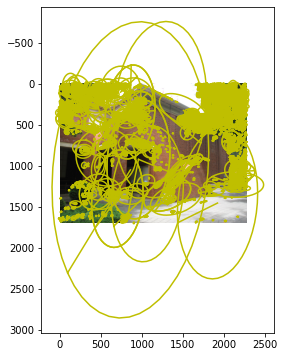

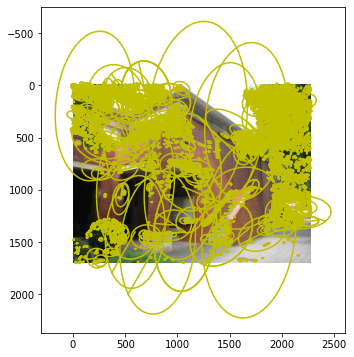

In [4]:
# Detecting DoG + HardNet + AffNet features
kornia_cv2dogaffnet = OpenCVDetectorWithAffNetKornia(cv2.SIFT_create(desired_kpts), max_kpts=desired_kpts)
dogaffnethardnet = KF.LocalFeature(kornia_cv2dogaffnet, KF.LAFDescriptor(KF.HardNet(True))).eval()

# Detecting features in the source image
lafs1, r1, descs1 = dogaffnethardnet(img1)
# Detecting features in the destination image
lafs2, r2, descs2 = dogaffnethardnet(img2)

# Visualizing the found affine correspondences
visualize_LAF(img1, lafs1, 0, 'y', figsize=(8,6))
visualize_LAF(img2, lafs2, 0, 'y', figsize=(8,6))

In [5]:
# Initialize a brute-force matcher to match the descriptors
bf = cv2.BFMatcher()

# Send the detected keypoints and other variables to the CPU and convert them to numpy array
descs1np = np.squeeze(descs1.cpu().detach().numpy())
descs2np = np.squeeze(descs2.cpu().detach().numpy())
lafs1np = np.squeeze(lafs1.cpu().detach().numpy())
lafs2np = np.squeeze(lafs2.cpu().detach().numpy())
r1np = np.squeeze(r1.cpu().detach().numpy())
r2np = np.squeeze(r2.cpu().detach().numpy())

# The threshold for the SNN ratio test
SNN_threshold = 0.85

# Applying brute-force matcher
matches = bf.knnMatch(descs1np, descs2np, k = 2)
 
# Apply the SNN ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

# Sort the keypoints based on the SNN ratio.
# This is used in many samplers, e.g., PROSAC, NG-RANSAC's, AR-Sampler
sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

print(f"{len(tentatives)} tentative correspondences are found.")


438 tentative correspondences are found.


In [8]:
# A function to convert the point ordering to probabilities used in NG-RANSAC's sampler or AR-Sampler.
def get_probabilities(tentatives):
    probabilities = []
    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities

# A function to convert to local affine frames (LAFs) to their centroids to obtain simple keypoints
def get_coordinates(lafs1, lafs2):
    kps1 = [ [lafs1[i, 0, 2], lafs1[i, 1, 2]] for i in range(lafs1.shape[0]) ]
    kps2 = [ [lafs2[i, 0, 2], lafs2[i, 1, 2]] for i in range(lafs2.shape[0]) ]
    return kps1, kps2

# A function to convert pairs of LAFs to affine correspondences (ACs)
def get_affine_correspondences(lafs1, lafs2, tentatives):
    # Initialize the ACs
    ACs = np.zeros((len(tentatives), 8))
    row = 0
    # Iterate through all tentative correspondences and them to the matrix
    for m in tentatives:
        # The LAF in the source image
        LAF1 = lafs1[m.queryIdx]
        # The LAF in the destination image
        LAF2 = lafs2[m.trainIdx]
        # Calculating the local affine transformation as A = LAF2 * inv(LAF1)
        A = np.matmul(LAF2[:, :2], np.linalg.inv(LAF1[:, :2]))

        # Saving the coordinates in the ACs matrix
        ACs[row, 0] = LAF1[0, 2]
        ACs[row, 1] = LAF1[1, 2]
        ACs[row, 2] = LAF2[0, 2]
        ACs[row, 3] = LAF2[1, 2]
        ACs[row, 4] = A[0, 0]
        ACs[row, 5] = A[0, 1]
        ACs[row, 6] = A[1, 0]
        ACs[row, 7] = A[1, 1]
        row += 1

    return np.float32(ACs)
    
# A function to run OpenCV's RANSAC on the point correspondences extracted from the affine frames
def verify_cv2_fundamental_matrix(kps1, kps2, tentatives):
    # Copy the coordinates in the source image selected by the tentative correspondences
    src_pts = np.float32([ kps1[m.queryIdx] for m in tentatives ]).reshape(-1,1,2)
    # Copy the coordinates in the destination image selected by the tentative correspondences
    dst_pts = np.float32([ kps2[m.trainIdx] for m in tentatives ]).reshape(-1,1,2)
    # Apply OpenCV's RANSAC
    F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.RANSAC, 0.75)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return F, mask

def verify_affine_pygcransac_fundamental_matrix(ACs, tentatives, h1, w1, h2, w2, sampler_id):

    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks. This part can be straightforwardly replaced by a deep probability
    # predictor, e.g., NG-RANSAC, CLNet, OANet, Deep MAGSAC++.
    inlier_probabilities = []
    if sampler_id == 3 or sampler_id == 4:
        inlier_probabilities = get_probabilities(tentatives)

    # Run GC-RANSAC with the AC-based solver
    F, mask = pygcransac.findFundamentalMatrix(
        np.ascontiguousarray(ACs), # The input affine correspondences
        h1, w1, h2, w2, # The sizes of the input images
        threshold = 0.75, # The inlier-outlier threshold
        sampler = sampler_id, # The index of the sampler to be used. 0 - uniform, 1 - PROSAC, 2 - P-NAPSAC, 3 - NG-RANSAC's sampler, 4 - AR-Sampler
        max_iters = 5000, # The maximum number of iterations
        min_iters = 50, # The minimum number of iterations
        probabilities = inlier_probabilities, # The inlier probabilities for all points
        spatial_coherence_weight = 0.6, # The weight for the spatial coherence term. It seems this is important for ACs.
        neighborhood = 1, # Neighborhood type. 0 - grid-based (faster/less accurate), 1 - FLANN-based (slower/more accurate).
        neighborhood_size = 20, # The neighborhood size. For grid-based neighborhood, it is the division number along each axis, 8 works well. For FLANN, it is the radius of the hypersphere used.
        solver = Solver.AffineBased.value) # The id of the used solver. 0 - point-based, 1 - SIFT-based, 2 - AC-based
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return F, mask

# Extracting the point correspondences to OpenCV RANSAC can run
kps1, kps2 = get_coordinates(lafs1np, lafs2np)

# The time before starting the estimation with OpenCV's RANSAC
t = time()
# Running OpenCV's RANSAC for fundamental matrix estimation
cv2_F, cv2_mask = verify_cv2_fundamental_matrix(kps1, kps2, tentatives)
# Measuring the run-time
print (time()-t, 'sec cv2')

# Extracting the affine correspondence so GC-RANSAC with affine solver can run
ACs = get_affine_correspondences(lafs1np, lafs2np, tentatives) 

# The time before starting the estimation with OpenCV's RANSAC
t = time()
gc_F, gc_mask = verify_affine_pygcransac_fundamental_matrix(ACs, # The input affine correspondences
    tentatives, # The matches containing the indices of the matched keypoints
    img1.shape[2], # The width of the source image
    img1.shape[3], # The height of the source image
    img2.shape[2], # The width of the destination image
    img2.shape[3], # The height of the destination image
    Sampler.ARSampler.value) # The id of the used sampler. 0 - uniform, 1 - PROSAC, 3 - NG-RANSAC's sampler, 4 - AR-Sampler
# Measuring the run-time
print (time()-t, 'sec pygcransac-ac')

189.0 inliers found
0.012227535247802734 sec cv2
277.0 inliers found
0.004383563995361328 sec pygcransac-ac


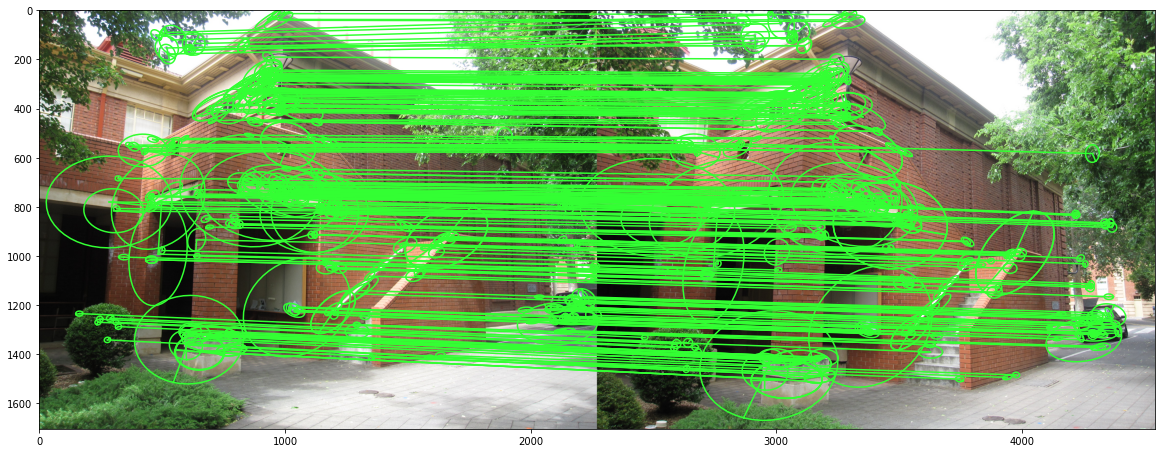

: 

In [9]:
tent_idxs = torch.from_numpy(np.array([[m.queryIdx, m.trainIdx] for m in tentatives]))

with torch.no_grad():
    draw_LAF_matches(lafs1, lafs2, tent_idxs,
                    img1, img2, 
                    inlier_mask = gc_mask,
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": None, 
                               "feature_color": None,
                               "vertical": False})